# Classification multi-classe et stacking

On cherche à prédire la note d'un vin avec un classifieur multi-classe puis à améliorer le score obtenu avec une méthode dite de [stacking](https://www.quora.com/What-is-stacking-in-machine-learning).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Le problème

Il n'est pas évident que les scores des différents modèles qu'on apprend sur chacun des classes soient comparables. Si le modèle n'est pas assez performant, on peut songer à ajouter un dernier modèle qui prend la décision finale en fonction du résultat de chaque modèle.

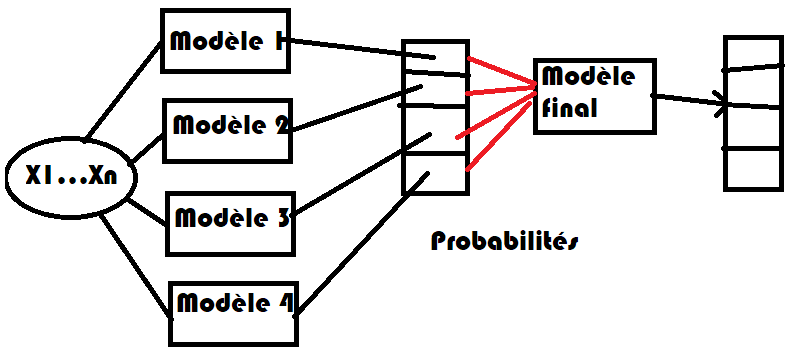

In [2]:
from pyquickhelper.helpgen import NbImage
NbImage('images/stackmulti.png', width=400)

In [3]:
%matplotlib inline

In [4]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
clr = OneVsRestClassifier(LogisticRegression())
clr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [7]:
import numpy
numpy.mean(clr.predict(X_test).ravel() == y_test.ravel()) * 100

52.246153846153845

On regarde la matrice de confusion.

In [8]:
from sklearn.metrics import confusion_matrix
import pandas
df = pandas.DataFrame(confusion_matrix(y_test, clr.predict(X_test)))
df.columns = [str(_) for _ in clr.classes_][:df.shape[1]]
df.index = [str(_) for _ in clr.classes_][:df.shape[0]]
df

,3,4,5,6,7,8
3,0,0,8,4,0,0
4,0,0,32,16,0,0
5,0,0,314,215,3,0
6,0,0,178,521,6,0
7,0,0,21,250,14,0
8,0,0,1,37,5,0


On cale d'abord une random forest sur les données brutes.

In [9]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
numpy.mean(rfc.predict(X_test).ravel() == y_test.ravel()) * 100

c:\python370_x64\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


64.98461538461538

On cale une random forest avec les sorties de la régression logistique.

In [10]:
rf_train = clr.decision_function(X_train)

rfc_y = RandomForestClassifier()
rfc_y.fit(rf_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

On calcule le taux d'erreur.

In [11]:
rf_test = clr.decision_function(X_test)
numpy.mean(rfc_y.predict(rf_test).ravel() == y_test.ravel()) * 100

64.12307692307692

C'est presque équivalent à une random forest calée sur les données brutes. On trace les courbes ROC pour la classe 4.

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_lr, tpr_lr, th_lr = roc_curve(y_test == 4, clr.decision_function(X_test)[:, 2])
fpr_rfc, tpr_rfc, th_rfc = roc_curve(y_test == 4, rfc.predict_proba(X_test)[:, 2])
fpr_rfc_y, tpr_rfc_y, th_rfc_y = roc_curve(y_test == 4, rfc_y.predict_proba(rf_test)[:, 2])
auc_lr = roc_auc_score(y_test == 4, clr.decision_function(X_test)[:, 2])
auc_rfc = roc_auc_score(y_test == 4, rfc.predict_proba(X_test)[:, 2])
auc_rfc_y = roc_auc_score(y_test == 4, rfc_y.predict_proba(rf_test)[:, 2])
auc_lr, auc_rfc, auc_rfc_y

(0.7012259564574086, 0.6295775206087508, 0.6297492601986895)

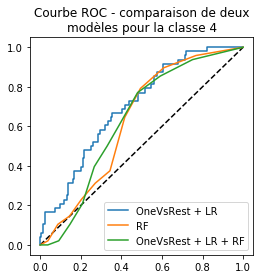

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="RF")
ax.plot(fpr_rfc_y, tpr_rfc_y, label="OneVsRest + LR + RF")
ax.set_title('Courbe ROC - comparaison de deux\nmodèles pour la classe 4')
ax.legend();

La courbe ROC ne montre rien de probant. Il faudrait vérifier avec une cross-validation qu'il serait pratique de faire avec un [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) mais ceux-ci n'acceptent qu'un seul prédicteur final.

In [14]:
from sklearn.pipeline import make_pipeline
try:
    pipe = make_pipeline(OneVsRestClassifier(LogisticRegression()), RandomForestClassifier())
except Exception as e:
    print('ERREUR :')
    print(e)

ERREUR :
All intermediate steps should be transformers and implement fit and transform. 'OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)' (type <class 'sklearn.multiclass.OneVsRestClassifier'>) doesn't


On construit une ROC sur toutes les classes.

In [15]:
fpr_lr, tpr_lr, th_lr = roc_curve(y_test == clr.predict(X_test), 
                                  clr.predict_proba(X_test).max(axis=1), drop_intermediate=False)
fpr_rfc, tpr_rfc, th_rfc = roc_curve(y_test == rfc.predict(X_test), 
                                  rfc.predict_proba(X_test).max(axis=1), drop_intermediate=False)
fpr_rfc_y, tpr_rfc_y, th_rfc_y = roc_curve(y_test == rfc_y.predict(rf_test), 
                                     rfc_y.predict_proba(rf_test).max(axis=1), drop_intermediate=False)
auc_lr = roc_auc_score(y_test == clr.predict(X_test), 
                       clr.decision_function(X_test).max(axis=1))
auc_rfc = roc_auc_score(y_test == rfc.predict(X_test), 
                        rfc.predict_proba(X_test).max(axis=1))
auc_rfc_y = roc_auc_score(y_test == rfc_y.predict(rf_test), 
                          rfc_y.predict_proba(rf_test).max(axis=1))
auc_lr, auc_rfc, auc_rfc_y

(0.5549129964907168, 0.7394468631836821, 0.6850388321706178)

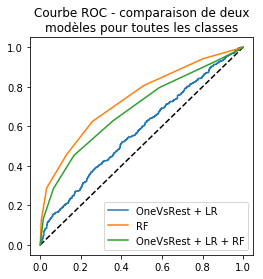

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="RF")
ax.plot(fpr_rfc_y, tpr_rfc_y, label="OneVsRest + LR + RF")
ax.set_title('Courbe ROC - comparaison de deux\nmodèles pour toutes les classes')
ax.legend();

Sur ce modèle, le score produit par le classifieur final paraît plus partinent que le score obtenu en prenant le score maximum sur toutes les classes. On tente une dernière approche où le modèle final doit valider ou non la réponse : c'est un classifieur binaire. Avec celui-ci, tous les classifieurs estimés sont binaires.

In [17]:
rf_train_bin = clr.decision_function(X_train)
y_train_bin = clr.predict(X_train) == y_train
rfc = RandomForestClassifier()
rfc.fit(rf_train_bin, y_train_bin)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

On regarde les premières réponses.

In [18]:
rf_test_bin = clr.decision_function(X_test)
rfc.predict_proba(rf_test_bin)[:3]

array([[0.1, 0.9],
       [0.4, 0.6],
       [0.3, 0.7]])

In [19]:
y_test_bin = clr.predict(X_test) == y_test

In [20]:
fpr_rfc_bin, tpr_rfc_bin, th_rfc_bin = roc_curve(y_test_bin, rfc.predict_proba(rf_test_bin)[:, 1])
auc_rfc_bin = roc_auc_score(y_test_bin, rfc.predict_proba(rf_test_bin)[:, 1])
auc_lr, auc_rfc_bin

(0.5549129964907168, 0.7351022427841123)

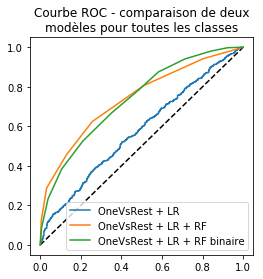

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="OneVsRest + LR + RF")
ax.plot(fpr_rfc_bin, tpr_rfc_bin, label="OneVsRest + LR + RF binaire")
ax.set_title('Courbe ROC - comparaison de deux\nmodèles pour toutes les classes')
ax.legend();

Un peu mieux mais il faudrait encore valider avec une validation croisée et plusieurs jeux de données, y compris artificiels. Il reste néanmoins l'idée.

## Automatisation avec une implémentation

Comme c'est fastidieux de faire tout cela, on implémente une classe qui convertit un modèle de machine learning en un *transform* qu'on peut insérer dans un pipeline.

In [22]:
from mlinsights.sklapi import SkBaseTransformStacking
model = make_pipeline(
                SkBaseTransformStacking([OneVsRestClassifier(LogisticRegression())], 'decision_function'), 
                RandomForestClassifier())
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('skbasetransformstacking', SkBaseTransformStacking([OneVsRestClassifier(estimator=LogisticRegress
    ion(C=1.0, class_weight=None, dual=False, fit_intercept=True,
    intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
    penalty='l2', random_state=None, solver='liblinear', tol...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [23]:
fpr_pipe, tpr_pipe, th_pipe = roc_curve(y_test == model.predict(X_test), 
                                  model.predict_proba(X_test).max(axis=1), drop_intermediate=False)
auc_pipe = roc_auc_score(y_test == model.predict(X_test), 
                       model.predict_proba(X_test).max(axis=1))
auc_pipe

0.7098552099016484

On n'oublie pas de mélanger les données avant de faire tourner la validation croisée.

In [24]:
df = load_wines_dataset(shuffle=True)
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']

On retrouve les mêmes résultats mais on peut maintenant faire une validation croisée.

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
cross_val_score(model, X, y, cv=5)

array([0.64285714, 0.63461538, 0.63461538, 0.63405239, 0.62528913])